# **TEXT MINING SPARCITY REDUCTION**

## **Project Purpose**
In text mining, analysts often remove words based on how many documents they occur in, i.e. removing words occurring in 1% of documents. However, this does not guarantee that models are being fed important words.

This project examines alternatives to document-frequency-based word selection, namely through the identification of "important words." Different techniques ranks words differently, and these ranks may allow one to select words that ensure models have only the information needed to perform well.

Ideally, this will reveal a process that selects words in a manner that enhances supervised classification model performance. The findings of this work could improve text mining practices going forward. For instance, it could help models classify IT support tickets, review topics, and project descriptions more accurately.

## **Project Goal**
Determine which approach to text feature selection produces the best multinomial naive-bayes model:
* Selecting words based on feature importances determined by TF-IDF rankings.
* Selecting words based on feature importances determined by KS test rankings.
* Selecting words based on the mean of TF-IDF and KS test feature importance rankings.

## **Data Used**
This project uses a collection of Amazon fashion product reviews scraped in 2018. Several products are included in the review set. Further information on products is provided in a metadata file. Both files are in JSON format.


---


**Citation**

Justifying recommendations using distantly-labeled reviews and fined-grained aspects

Jianmo Ni, Jiacheng Li, Julian McAuley

Empirical Methods in Natural Language Processing (EMNLP), 2019

## **Project Design**
This project was ran in Python version 3.11.5.

Prior to testing various sparcity reduction methods, a number of standard text preprocessing techniques are used on the review texts:
* Lowercasing
* Removal of punctuation and special characters
* Removal of stop words
* Removal of noise, like URLs and HTML tags
* Lemmatization
* Tokenization

Sparcity reduction via various word ranking techniques was tested at the following word counts:
* 272 words
* 334 words
* 404 words
* 553 words
* 834 words

At each word count, data loss was tested by checking the number of non-null entries after filtering the entire review text column to the top x words. Review text training and testing sets were filtered to the top x words. Then, said sets were given to a multinomial naive-bayes model for classification. Specifically, the model tries to predict the topic of review texts as identified through LDA. No over or undersampling was performed and no parameters were adjusted in the model.

# **IMPORTS**

In [1]:
# Parallelization
%pip install swifter
import swifter

# Data access and manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Text preprocessing
import re
%pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Topic modeling
%pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint

# Sparcity reduction techniques
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats

# TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

# Classification model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

Note: you may need to restart the kernel to use updated packages.


c:\Users\maxwe\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxwe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Note: you may need to restart the kernel to use updated packages.


# **DATA PREPARATION**

## **Fetching Data**

In [2]:
# Fetch data files
df = pd.read_json('AMAZON_FASHION.json', lines = True)

# Show first 5 rows of "df"
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [3]:
# Find most commonly reviewed item
df['asin'].value_counts()

asin
B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
              ... 
B00VQHSOE0       1
B00VQH61O0       1
B00VQGEHII       1
B00VQGZT76       1
B01HJG5NMW       1
Name: count, Length: 186189, dtype: int64

In [4]:
# Filter to the most commonly reviewed item
df = df.loc[df['asin'] == 'B000V0IBDM']
df = df['reviewText']
# Get information on the resulting dataset
df.info()

<class 'pandas.core.series.Series'>
Index: 4384 entries, 24715 to 402442
Series name: reviewText
Non-Null Count  Dtype 
--------------  ----- 
4380 non-null   object
dtypes: object(1)
memory usage: 68.5+ KB


In [5]:
# Drop null entries
df.dropna(inplace=True)

# Confirm dropping
df.info()

<class 'pandas.core.series.Series'>
Index: 4380 entries, 24715 to 402442
Series name: reviewText
Non-Null Count  Dtype 
--------------  ----- 
4380 non-null   object
dtypes: object(1)
memory usage: 68.4+ KB


In [6]:
# Show first five rows of "df"
df.head()

24715    I  lo ed the old style but these are so much b...
24716                                      Average insole.
24717    I buy a new pair of these every six months. I ...
24718    My podiatrist recommended these Powerstep Inso...
24719    They worked well for the first few weeks and t...
Name: reviewText, dtype: object

## **Text Preprocessing**

### **LOWERCASING**

In [7]:
# Convert all words to lowercase
df = df.str.lower()

### **REMOVAL OF PUNCTUATION AND SPECIAL CHARACTERS**

In [8]:
# Remove punctuation and special characters
df = df.swifter.apply(lambda x: re.sub(r'[^\w\s]', '', x))

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 163660.47it/s]


### **REMOVAL OF STOPWORDS**

In [9]:
# Define stopwords
stpwrds = stopwords.words('english')

# Remove stopwords
df = df.swifter.apply(lambda x: ' '.join(word for word in x.split() if word not in (stpwrds)))

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 17000.02it/s]


### **REMOVAL OF URLS AND HTML TAGS**

In [10]:
# Remove URLs
def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)
df = df.swifter.apply(remove_urls)

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 296992.28it/s]


### **LEMMATIZATION**

In [11]:
# Define lemmatizer
lemmatize = WordNetLemmatizer()

# Lemmatize
def lemmatizer(text):
  words = text.split()
  words = [lemmatize.lemmatize(word, pos='v') for word in words]
  return ' '.join(words)
df = df.swifter.apply(lemmatizer)

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 12463.31it/s]


### **REMOVE ALPHANUMERIC WORDS**

In [12]:
# Define alphanumeric word removal function
def remove_alphanumeric(text):
  return ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

# Remove alphanumeric words
df = df.swifter.apply(remove_alphanumeric)

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 55554.03it/s]


### **TOKENIZATION**

In [13]:
# Tokenize
def tokenize_text(text):
  tokens = word_tokenize(text)
  return tokens
df = df.swifter.apply(tokenize_text)

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 8426.95it/s] 


### **FINAL CONFIRMATIONS**

In [14]:
# Check for null values
df.info()

<class 'pandas.core.series.Series'>
Index: 4380 entries, 24715 to 402442
Series name: reviewText
Non-Null Count  Dtype 
--------------  ----- 
4380 non-null   object
dtypes: object(1)
memory usage: 197.5+ KB


In [15]:
# Show dataframe
df.head()

24715            [lo, ed, old, style, much, better, thank]
24716                                    [average, insole]
24717    [buy, new, pair, every, six, months, feet, lot...
24718    [podiatrist, recommend, powerstep, insoles, of...
24719    [work, well, first, weeks, go, little, hill, e...
Name: reviewText, dtype: object

# **TOPIC MODELING**

## **Preparing Data for LDA**

In [16]:
# Create a corpus suitable for LDA
id2word = corpora.Dictionary(df)
corpus = [id2word.doc2bow(text) for text in df]

# Show corpus
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(8, 1), (11, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(8, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1)], [(23, 1), (65, 1)], [(12, 2), (19, 1), (21, 1), (30, 1), (35, 1), (43, 1), (48, 1), (50, 1), (55, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 2), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2)], [(23, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1)], [(13, 1), (19, 1), (26,

## **Generating Coherence Scores at Various Topic Counts**

In [17]:
# Create list of topic counts
topiccounts = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# Run LDA, testing various numbers of topics
for topiccount in topiccounts:
    lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = topiccount,
                                           random_state=0)
    coherence = CoherenceModel(model=lda_model, texts = df, dictionary = id2word, coherence='c_v')
    print(f'Coherence at {topiccount} topics: {coherence.get_coherence()}')

Coherence at 1 topics: 0.5350785130605848
Coherence at 2 topics: 0.5583939084544021
Coherence at 3 topics: 0.5490507411699032
Coherence at 4 topics: 0.5521714565856042
Coherence at 5 topics: 0.5405068399386079
Coherence at 6 topics: 0.5370670443263452
Coherence at 7 topics: 0.5336255978123997
Coherence at 8 topics: 0.5444334090739551
Coherence at 9 topics: 0.5432894523918335
Coherence at 10 topics: 0.5370438801336849
Coherence at 11 topics: 0.5395621963582681
Coherence at 12 topics: 0.5388566093563459
Coherence at 13 topics: 0.5336967716437268
Coherence at 14 topics: 0.5346301412377251
Coherence at 15 topics: 0.5286839741555603


## **Labeling Texts**

In [18]:
# Build model that creates two topics
lda2 = gensim.models.LdaMulticore(corpus = corpus,
                                  id2word = id2word,
                                  num_topics = 2,
                                  random_state=0)

# Get topics
topics = lda2.get_document_topics(corpus)

# Get CSR
alltopicscsr = gensim.matutils.corpus2csc(topics)

# Convert to a numpy array
alltopicsnumpy = alltopicscsr.T.toarray()

# Convert to a dataframe
df2 = pd.DataFrame(alltopicsnumpy)

# Show dataframe
df2.head()

,0,1
0,0.447967,0.552033
1,0.649862,0.350138
2,0.916563,0.083437
3,0.049511,0.950489
4,0.967936,0.032065


In [19]:
# Create new column
df2['label'] = ' '

# Fill column
df2.loc[(df2[0] > df2[1]), 'label'] = 0
df2.loc[df2[0] < df2[1], 'label'] = 1
df2.loc[df2[0] == df2[1], 'label'] = 2

# Confirm dataframe
df2.head()

,0,1,label
0,0.447967,0.552033,1
1,0.649862,0.350138,0
2,0.916563,0.083437,0
3,0.049511,0.950489,1
4,0.967936,0.032065,0


In [20]:
# Get value counts for "label"
df2['label'].value_counts()

label
1    2256
0    2122
2       2
Name: count, dtype: int64

In [21]:
# Replace 2 with 1
df2.loc[df2['label'] == 2, 'label'] = 1

# Confirm operation
df2['label'].value_counts()

label
1    2258
0    2122
Name: count, dtype: int64

In [22]:
# Convert "label" to int
df2['label'] = pd.to_numeric(df2['label'])

# Confirm operation
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4380 non-null   float64
 1   1       4380 non-null   float64
 2   label   4380 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 102.8 KB


In [23]:
# Append label to texts
df = df.to_frame()
df.reset_index(drop=True, inplace=True)
df['label'] = df2['label']

# Confirm dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  4380 non-null   object
 1   label       4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


# **INITIAL MODEL TEST**
Run the model with all of the words to provide a baseline.

## **Data Splitting**

In [24]:
# Join texts into strings
df['reviewText'] = df['reviewText'].swifter.apply(lambda x: ' '.join(x))

# Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(df['reviewText'], df['label'],
                                                test_size = 0.20,
                                                random_state = 0)

Pandas Apply: 100%|██████████| 4380/4380 [00:00<00:00, 335115.86it/s]


## **TF-IDF Vectorization and Data Preparations**
TF-IDF vectorizer results are converted to Pandas dataframes to make filtering to the top x words and removing sparse words easier.

In [25]:
# Define vectorizer
vectorizer = tfidf(norm = None)

# Vectorize Xtrain data and get feature names
Xtrain = vectorizer.fit_transform(Xtrain)
xtrfts = vectorizer.get_feature_names_out()

# Vectorize Xtest data and get feature names
Xtest = vectorizer.transform(Xtest)
xtsfts = vectorizer.get_feature_names_out()

# Create Pandas dataframes for the vectorized datasets
Xtrain = pd.DataFrame.sparse.from_spmatrix(Xtrain, columns = xtrfts)
Xtest = pd.DataFrame.sparse.from_spmatrix(Xtest, columns = xtsfts)

# Convert new Pandas dataframes to dense values
Xtrain = Xtrain.sparse.to_dense().astype(np.float64)
Xtest = Xtest.sparse.to_dense().astype(np.float64)

## **Model**

In [26]:
# Define the model to use
mdl = MultinomialNB()

# Define model run function
def model(xtr, xts, ytr, yts):
  mdl.fit(xtr, ytr)
  preds = mdl.predict(xts)
  print(classification_report(yts, preds))

# Use function
model(Xtrain, Xtest, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       432
           1       0.81      0.82      0.82       444

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876



# **DOCUMENT FREQUENCY REDUCTION**

In [27]:
# Define a function that counts the number of documents every word occurs in
def docs(corpus):
  doc_count = dict()
  for line in corpus:
    for word in line.split():
      if word in doc_count:
        doc_count[word] += 1
      else:
        doc_count[word] = 1
  return doc_count

# Create a Pandas dataframe with the number of documents every word occurs in
counts = docs(df['reviewText'])
counts = pd.DataFrame.from_dict(counts, orient='index')
counts.head()

,0
lo,2
ed,2
old,70
style,20
much,434


In [28]:
# Rename column and restructure dataframe
counts = counts.rename(columns={0:'doc_freq'})
counts = counts.reset_index()

# Check dataframe
counts.head()

,index,doc_freq
0,lo,2
1,ed,2
2,old,70
3,style,20
4,much,434


In [29]:
# Rename index and add percent column
counts = counts.rename(columns={'index':'word'})
counts['percent'] = (counts['doc_freq']/len(counts)) * 100

# Confirm dataframe
counts.head()

,word,doc_freq,percent
0,lo,2,0.047114
1,ed,2,0.047114
2,old,70,1.648999
3,style,20,0.471143
4,much,434,10.223793


array([[<Axes: title={'center': 'percent'}>]], dtype=object)

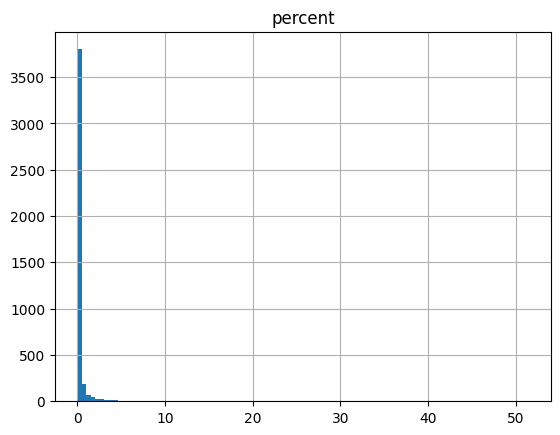

In [30]:
# Show distribution of "percent"
counts.hist(column='percent', bins=100)

In [31]:
# Get information on the dataframe
counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245 entries, 0 to 4244
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   word      4245 non-null   object 
 1   doc_freq  4245 non-null   int64  
 2   percent   4245 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 99.6+ KB


In [32]:
# Define a filtering function for the entire dataset
def filter_entries(words, percent):
    valid = list(words.loc[words['percent'] > percent, 'word'])
    data = df.explode('reviewText')
    data = data[data['reviewText'].isin(valid)]
    data = data.groupby(data.index).agg({'reviewText':list, 'label':'first'})
    data.info()

# Define a filtering function for the training and testing sets
def filter_sets(words, percent, dataset):
   valid = list(words.loc[words['percent'] > percent, 'word'])
   wordset = set(valid) & set(dataset.columns)
   words = list(wordset)
   dataset = dataset[words]
   return dataset

## **Remove Words Occuring <=1%**

In [33]:
# Get info on entire dataset after removing words occurring <=1%
filter_entries(counts, 1)

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  196 non-null    object
 1   label       196 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


In [34]:
# Filter the training and testing sets
xtr_percent_1 = filter_sets(counts, 1, Xtrain)
xts_percent_1 = filter_sets(counts, 1, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_percent_1.info()
print()
Xtest.info()
print()
xts_percent_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 272 entries, anyone to store
dtypes: float64(272)
memory usage: 7.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 272 entries, anyone to store
dtypes: float64(272)
memory usage: 1.8 MB


In [35]:
# Run the model
model(xtr_percent_1, xts_percent_1, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       432
           1       0.83      0.79      0.81       444

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876



## **Remove Words Occuring <=0.8%**

In [36]:
# Get info on entire dataset after removing words occurring <=0.8%
filter_entries(counts, 0.8)

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  197 non-null    object
 1   label       197 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


In [37]:
# Filter the training and testing sets
xtr_percent_8 = filter_sets(counts, 0.8, Xtrain)
xts_percent_8 = filter_sets(counts, 0.8, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_percent_8.info()
print()
Xtest.info()
print()
xts_percent_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 334 entries, anyone to store
dtypes: float64(334)
memory usage: 8.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 334 entries, anyone to store
dtypes: float64(334)
memory usage: 2.2 MB


In [38]:
# Run the model
model(xtr_percent_8, xts_percent_8, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       432
           1       0.85      0.81      0.83       444

    accuracy                           0.83       876
   macro avg       0.83      0.83      0.83       876
weighted avg       0.83      0.83      0.83       876



## **Remove Words Occuring <=0.6%**

In [39]:
# Get info on entire dataset after removing words occurring <=0.6%
filter_entries(counts, 0.6)

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  200 non-null    object
 1   label       200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [40]:
# Filter the training and testing sets
xtr_percent_6 = filter_sets(counts, 0.6, Xtrain)
xts_percent_6 = filter_sets(counts, 0.6, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_percent_6.info()
print()
Xtest.info()
print()
xts_percent_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 404 entries, anyone to store
dtypes: float64(404)
memory usage: 10.8 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 404 entries, anyone to store
dtypes: float64(404)
memory usage: 2.7 MB


In [41]:
# Run the model
model(xtr_percent_6, xts_percent_6, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       432
           1       0.86      0.83      0.85       444

    accuracy                           0.85       876
   macro avg       0.85      0.85      0.85       876
weighted avg       0.85      0.85      0.85       876



## **Remove Words Occuring <=0.4%**

In [42]:
# Get info on entire dataset after removing words occurring <=0.4%
filter_entries(counts, 0.4)

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  210 non-null    object
 1   label       210 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


In [43]:
# Filter the training and testing sets
xtr_percent_4 = filter_sets(counts, 0.4, Xtrain)
xts_percent_4 = filter_sets(counts, 0.4, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_percent_4.info()
print()
Xtest.info()
print()
xts_percent_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 553 entries, anyone to store
dtypes: float64(553)
memory usage: 14.8 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 553 entries, anyone to store
dtypes: float64(553)
memory usage: 3.7 MB


In [44]:
# Run the model
model(xtr_percent_4, xts_percent_4, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       432
           1       0.85      0.81      0.83       444

    accuracy                           0.83       876
   macro avg       0.83      0.83      0.83       876
weighted avg       0.83      0.83      0.83       876



## **Remove Words Occuring <=0.2%**

In [45]:
# Get info on entire dataset after removing words occurring <=0.2%
filter_entries(counts, 0.2)

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  212 non-null    object
 1   label       212 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ KB


In [46]:
# Filter the training and testing sets
xtr_percent_2 = filter_sets(counts, 0.2, Xtrain)
xts_percent_2 = filter_sets(counts, 0.2, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_percent_2.info()
print()
Xtest.info()
print()
xts_percent_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 834 entries, anyone to store
dtypes: float64(834)
memory usage: 22.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 834 entries, anyone to store
dtypes: float64(834)
memory usage: 5.6 MB


In [47]:
# Run the model
model(xtr_percent_2, xts_percent_2, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       432
           1       0.83      0.82      0.82       444

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876



# **TF-IDF REDUCTION**

In [48]:
# Perform TF-IDF vectorization on all documents at once
vectorizer = tfidf(norm=None)
matrix = vectorizer.fit_transform(df['reviewText'])

# Store features, calculate sum TF-IDF score for each word, and put them into a dataframe
feats = vectorizer.get_feature_names_out()
scores = matrix.sum(axis=0).A1
tfidf_ranks = pd.DataFrame({'Word': feats, 'TF-IDF Score': scores})
tfidf_ranks = tfidf_ranks.sort_values(by='TF-IDF Score', ascending=False)

# Define a filtering function for the entire dataset
def filter_entire(ranks, wordcount):
  valid = list(ranks['Word'].head(wordcount))
  data = df.explode('reviewText')
  data = data[data['reviewText'].isin(valid)]
  data = data.groupby(data.index).agg({'reviewText':list, 'label':'first'})
  data.info()

# Define a filtering function for the training and testing sets
def filter_partial(ranks, wordcount, dataset):
  valid = list(ranks['Word'].head(wordcount))
  wordset = set(valid) & set(dataset.columns)
  words = list(wordset)
  dataset = dataset[words]
  return dataset

## **272 Words**

In [49]:
# Get info on entire dataset after filtering to 272 words
filter_entire(tfidf_ranks, 272)

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  196 non-null    object
 1   label       196 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


Significant data loss.

In [50]:
# Filter the training and testing sets
xtr_tfidf_272 = filter_partial(tfidf_ranks, 272, Xtrain)
xts_tfidf_272 = filter_partial(tfidf_ranks, 272, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_tfidf_272.info()
print()
Xtest.info()
print()
xts_tfidf_272.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 272 entries, anyone to store
dtypes: float64(272)
memory usage: 7.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 272 entries, anyone to store
dtypes: float64(272)
memory usage: 1.8 MB


In [51]:
# Run the model
model(xtr_tfidf_272, xts_tfidf_272, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       432
           1       0.83      0.79      0.81       444

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876



## **334 Words**

In [52]:
# Get info on entire dataset after filtering to 334 words
filter_entire(tfidf_ranks, 334)

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  197 non-null    object
 1   label       197 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


Significant data loss.

In [53]:
# Filter the training and testing sets
xtr_tfidf_334 = filter_partial(tfidf_ranks, 334, Xtrain)
xts_tfidf_334 = filter_partial(tfidf_ranks, 334, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_tfidf_334.info()
print()
Xtest.info()
print()
xts_tfidf_334.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 334 entries, anyone to store
dtypes: float64(334)
memory usage: 8.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 334 entries, anyone to store
dtypes: float64(334)
memory usage: 2.2 MB


In [54]:
# Run the model
model(xtr_tfidf_334, xts_tfidf_334, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       432
           1       0.85      0.81      0.83       444

    accuracy                           0.83       876
   macro avg       0.83      0.83      0.83       876
weighted avg       0.83      0.83      0.83       876



## **404 Words**

In [55]:
# Get info on entire dataset after filtering to 404 words
filter_entire(tfidf_ranks, 404)

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  200 non-null    object
 1   label       200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


Significant data loss.

In [56]:
# Filter the training and testing sets
xtr_tfidf_404 = filter_partial(tfidf_ranks, 404, Xtrain)
xts_tfidf_404 = filter_partial(tfidf_ranks, 404, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_tfidf_404.info()
print()
Xtest.info()
print()
xts_tfidf_404.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 404 entries, anyone to store
dtypes: float64(404)
memory usage: 10.8 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 404 entries, anyone to store
dtypes: float64(404)
memory usage: 2.7 MB


In [57]:
# Run the model
model(xtr_tfidf_404, xts_tfidf_404, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       432
           1       0.86      0.83      0.84       444

    accuracy                           0.84       876
   macro avg       0.84      0.84      0.84       876
weighted avg       0.84      0.84      0.84       876



## **553 Words**

In [58]:
# Get info on entire dataset after filtering to 553 words
filter_entire(tfidf_ranks, 553)

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  210 non-null    object
 1   label       210 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


Significant data loss.

In [59]:
# Filter the training and testing sets
xtr_tfidf_553 = filter_partial(tfidf_ranks, 553, Xtrain)
xts_tfidf_553 = filter_partial(tfidf_ranks, 553, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_tfidf_553.info()
print()
Xtest.info()
print()
xts_tfidf_553.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 553 entries, anyone to store
dtypes: float64(553)
memory usage: 14.8 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 553 entries, anyone to store
dtypes: float64(553)
memory usage: 3.7 MB


In [60]:
# Run the model
model(xtr_tfidf_553, xts_tfidf_553, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       432
           1       0.85      0.81      0.83       444

    accuracy                           0.83       876
   macro avg       0.83      0.83      0.83       876
weighted avg       0.83      0.83      0.83       876



## **834 Words**

In [61]:
# Get info on entire dataset after filtering to 834 words
filter_entire(tfidf_ranks, 834)

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  212 non-null    object
 1   label       212 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ KB


Significant data loss.

In [62]:
# Filter the training and testing sets
xtr_tfidf_834 = filter_partial(tfidf_ranks, 834, Xtrain)
xts_tfidf_834 = filter_partial(tfidf_ranks, 834, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_tfidf_834.info()
print()
Xtest.info()
print()
xts_tfidf_834.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 834 entries, anyone to store
dtypes: float64(834)
memory usage: 22.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 834 entries, anyone to store
dtypes: float64(834)
memory usage: 5.6 MB


In [63]:
# Run the model
model(xtr_tfidf_834, xts_tfidf_834, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       432
           1       0.83      0.82      0.82       444

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876



# **KS TEST REDUCTION**

In [64]:
# Define Vectorizer
vectorizer = CountVectorizer()

# Vectorize the text data and convert it to a dataframe
txt = vectorizer.fit_transform(df['reviewText'])
count_df = pd.DataFrame(txt.toarray(), columns=vectorizer.get_feature_names_out())

# Reset indeces
count_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Append category labels to count_df
count_df['label'] = df['label']

# Get all unique outputs
outputs = [0,1]

# Initialize a list that will store the occurence of p-value = 1 for each word
ksscore = []

# Iterate through each word
for word in feats:
  # Initialize matrices
  ks_matrix = np.zeros((len(outputs), len(outputs)))
  p_value_matrix = np.zeros((len(outputs), len(outputs)))
  # Iterate over outputs
  for output1 in range(len(outputs)):
    for output2 in range(len(outputs)):
      # Get samples for the combination of input types
      sample1 = count_df.loc[count_df['label'] == outputs[output1], word].values
      sample2 = count_df.loc[count_df['label'] == outputs[output2], word].values
      # KS test
      ks_statistic, p_value = stats.ks_2samp(sample1, sample2)
      # Assign KS statistic an p-value to the corresponding indices in the matrices
      ks_matrix[output1, output2] = ks_statistic
      # Adjust p-value using the Bonferroni correction
      bonferroni = p_value * 1
      # Modify Bonferroni correction
      if bonferroni < 0.05:
        bonferroni = 1
      else:
        bonferroni = 0
      p_value_matrix[output1, output2] = bonferroni
  # Count the occurrences of significant results after Bonferroni correction
  score = np.count_nonzero(p_value_matrix == 1) / (len(outputs)**2)
  ksscore.append(score)

# Convert occurrence list to a dataframe
ks_ranks = pd.DataFrame({'Word': count_df.columns, 'KS Score': ksscore})
ks_ranks = ks_ranks.sort_values(by='KS Score', ascending=False)

# Confirm dataframe
ks_ranks.head()

,Word,KS Score
3624,support,0.5
220,arch,0.5
2679,pinnacle,0.5
2087,love,0.5
2751,powerstep,0.5


## **272 Words**

In [65]:
# Get info on entire dataset after filtering to 272 words
filter_entire(ks_ranks, 272)

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 20 to 3678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  87 non-null     object
 1   label       87 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


Significant data loss.

In [66]:
# Filter the training and testing setsD
xtr_ks_272 = filter_partial(ks_ranks, 272, Xtrain)
xts_ks_272 = filter_partial(ks_ranks, 272, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_ks_272.info()
print()
Xtest.info()
print()
xts_ks_272.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 246 entries, quicker to pro
dtypes: float64(246)
memory usage: 6.6 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 246 entries, quicker to pro
dtypes: float64(246)
memory usage: 1.6 MB


In [67]:
# Run the model
model(xtr_ks_272, xts_ks_272, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       432
           1       0.75      0.75      0.75       444

    accuracy                           0.74       876
   macro avg       0.74      0.74      0.74       876
weighted avg       0.74      0.74      0.74       876



## **334 Words**

In [68]:
# Get info on entire dataset after filtering to 334 words
filter_entire(ks_ranks, 334)

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 20 to 3678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  88 non-null     object
 1   label       88 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


Significant data loss.

In [69]:
# Filter the training and testing sets
xtr_ks_334 = filter_partial(ks_ranks, 334, Xtrain)
xts_ks_334 = filter_partial(ks_ranks, 334, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_ks_334.info()
print()
Xtest.info()
print()
xts_ks_334.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 296 entries, quicker to pro
dtypes: float64(296)
memory usage: 7.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 296 entries, quicker to pro
dtypes: float64(296)
memory usage: 2.0 MB


In [70]:
# Run the model
model(xtr_ks_334, xts_ks_334, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       432
           1       0.75      0.75      0.75       444

    accuracy                           0.75       876
   macro avg       0.75      0.75      0.75       876
weighted avg       0.75      0.75      0.75       876



## **404 Words**

In [71]:
# Get info on entire dataset after filtering to 404 words
filter_entire(ks_ranks, 404)

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 20 to 3678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  89 non-null     object
 1   label       89 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


Significant data loss.

In [72]:
# Filter the training and testing sets
xtr_ks_404 = filter_partial(ks_ranks, 404, Xtrain)
xts_ks_404 = filter_partial(ks_ranks, 404, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_ks_404.info()
print()
Xtest.info()
print()
xts_ks_404.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 354 entries, route to runningjogging
dtypes: float64(354)
memory usage: 9.5 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 354 entries, route to runningjogging
dtypes: float64(354)
memory usage: 2.4 MB


In [73]:
# Run the model
model(xtr_ks_404, xts_ks_404, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       432
           1       0.74      0.75      0.75       444

    accuracy                           0.74       876
   macro avg       0.74      0.74      0.74       876
weighted avg       0.74      0.74      0.74       876


## **553 Words**

In [74]:
# Get info on entire dataset after filtering to 553 words
filter_entire(ks_ranks, 553)

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 20 to 3678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  90 non-null     object
 1   label       90 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


Significant data loss.

In [75]:
# Filter the training and testing sets
xtr_ks_553 = filter_partial(ks_ranks, 553, Xtrain)
xts_ks_553 = filter_partial(ks_ranks, 553, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_ks_553.info()
print()
Xtest.info()
print()
xts_ks_553.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 482 entries, rely to runningjogging
dtypes: float64(482)
memory usage: 12.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 482 entries, rely to runningjogging
dtypes: float64(482)
memory usage: 3.2 MB


In [76]:
# Run the model
model(xtr_ks_553, xts_ks_553, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       432
           1       0.75      0.77      0.76       444

    accuracy                           0.76       876
   macro avg       0.76      0.76      0.76       876
weighted avg       0.76      0.76      0.76       876



## **834 Words**

In [77]:
# Get info on entire dataset after filtering to 834 words
filter_entire(ks_ranks, 834)

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, 20 to 3678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  92 non-null     object
 1   label       92 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


Significant data loss.

In [78]:
# Filter the training and testing sets
xtr_ks_834 = filter_partial(ks_ranks, 834, Xtrain)
xts_ks_834 = filter_partial(ks_ranks, 834, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_ks_834.info()
print()
Xtest.info()
print()
xts_ks_834.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 733 entries, rely to mei
dtypes: float64(733)
memory usage: 19.6 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 733 entries, rely to mei
dtypes: float64(733)
memory usage: 4.9 MB


In [79]:
# Run the model
model(xtr_ks_834, xts_ks_834, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       432
           1       0.76      0.79      0.78       444

    accuracy                           0.77       876
   macro avg       0.77      0.77      0.77       876
weighted avg       0.77      0.77      0.77       876



# **KS TEST + TF-IDF REDUCTION**

In [80]:
# Get ranks for KS and TF-IDF
ks_ranks.reset_index(drop=True, inplace=True)
ks_ranks.reset_index(inplace=True)
tfidf_ranks.reset_index(drop=True, inplace=True)
tfidf_ranks.reset_index(inplace=True)

# Confirm dataframes
ks_ranks.info()
tfidf_ranks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     4232 non-null   int64  
 1   Word      4232 non-null   object 
 2   KS Score  4232 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 99.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         4232 non-null   int64  
 1   Word          4232 non-null   object 
 2   TF-IDF Score  4232 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 99.3+ KB


In [81]:
# Combine ranks into one dataframe
mean_ranks = tfidf_ranks.merge(ks_ranks, on='Word', suffixes=('_tfidf', '_ks'))

# Confirm
mean_ranks.info()
mean_ranks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index_tfidf   4232 non-null   int64  
 1   Word          4232 non-null   object 
 2   TF-IDF Score  4232 non-null   float64
 3   index_ks      4232 non-null   int64  
 4   KS Score      4232 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 165.4+ KB


,index_tfidf,Word,TF-IDF Score,index_ks,KS Score
0,0,shoe,4790.279701,1855,0.0
1,1,feet,3037.151713,5,0.5
2,2,support,2870.343367,0,0.5
3,3,arch,2788.423651,1,0.5
4,4,insoles,2785.654948,21,0.5


In [82]:
# Add 1 to the ranks
mean_ranks['index_tfidf'] = mean_ranks['index_tfidf']+1

# Confirm
mean_ranks.head()

,index_tfidf,Word,TF-IDF Score,index_ks,KS Score
0,1,shoe,4790.279701,1855,0.0
1,2,feet,3037.151713,5,0.5
2,3,support,2870.343367,0,0.5
3,4,arch,2788.423651,1,0.5
4,5,insoles,2785.654948,21,0.5


In [83]:
# Add 1 to the ranks
mean_ranks['index_ks'] = mean_ranks['index_ks']+1

# Calculate mean rank
mean_ranks['mean_rank'] = (mean_ranks['index_tfidf'] + mean_ranks['index_ks']) / 2

# Confirm
mean_ranks.head()

,index_tfidf,Word,TF-IDF Score,index_ks,KS Score,mean_rank
0,1,shoe,4790.279701,1856,0.0,928.5
1,2,feet,3037.151713,6,0.5,4.0
2,3,support,2870.343367,1,0.5,2.0
3,4,arch,2788.423651,2,0.5,3.0
4,5,insoles,2785.654948,22,0.5,13.5


In [84]:
# Collect relevant columns and order appropriately
mean_ranks = mean_ranks[['Word', 'mean_rank']]
mean_ranks = mean_ranks.sort_values(by='mean_rank')

## **272 Words**

In [85]:
# Get info on entire dataset after filtering to 272 words
filter_entire(mean_ranks, 272)

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  126 non-null    object
 1   label       126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


Significant data loss.

In [86]:
# Filter the training and testing setsD
xtr_mean_272 = filter_partial(mean_ranks, 272, Xtrain)
xts_mean_272 = filter_partial(mean_ranks, 272, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_mean_272.info()
print()
Xtest.info()
print()
xts_mean_272.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 272 entries, refund to pro
dtypes: float64(272)
memory usage: 7.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 272 entries, refund to pro
dtypes: float64(272)
memory usage: 1.8 MB


In [87]:
# Run the model
model(xtr_mean_272, xts_mean_272, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       432
           1       0.79      0.80      0.79       444

    accuracy                           0.79       876
   macro avg       0.79      0.79      0.79       876
weighted avg       0.79      0.79      0.79       876



## **334 Words**

In [88]:
# Get info on entire dataset after filtering to 334 words
filter_entire(mean_ranks, 334)

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  129 non-null    object
 1   label       129 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


Significant data loss.

In [89]:
# Filter the training and testing sets
xtr_mean_334 = filter_partial(mean_ranks, 334, Xtrain)
xts_mean_334 = filter_partial(mean_ranks, 334, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_mean_334.info()
print()
Xtest.info()
print()
xts_mean_334.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 334 entries, reason to months
dtypes: float64(334)
memory usage: 8.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 334 entries, reason to months
dtypes: float64(334)
memory usage: 2.2 MB


In [90]:
# Run the model
model(xtr_mean_334, xts_mean_334, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       432
           1       0.79      0.80      0.79       444

    accuracy                           0.79       876
   macro avg       0.79      0.79      0.79       876
weighted avg       0.79      0.79      0.79       876



## **404 Words**

In [91]:
# Get info on entire dataset after filtering to 404 words
filter_entire(mean_ranks, 404)

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  130 non-null    object
 1   label       130 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


Significant data loss.

In [92]:
# Filter the training and testing sets
xtr_mean_404 = filter_partial(mean_ranks, 404, Xtrain)
xts_mean_404 = filter_partial(mean_ranks, 404, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_mean_404.info()
print()
Xtest.info()
print()
xts_mean_404.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 404 entries, reason to months
dtypes: float64(404)
memory usage: 10.8 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 404 entries, reason to months
dtypes: float64(404)
memory usage: 2.7 MB


In [93]:
# Run the model
model(xtr_mean_404, xts_mean_404, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       432
           1       0.78      0.78      0.78       444

    accuracy                           0.78       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.78      0.78      0.78       876



## **553 Words**

In [94]:
# Get info on entire dataset after filtering to 553 words
filter_entire(mean_ranks, 553)

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  136 non-null    object
 1   label       136 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


Significant data loss.

In [95]:
# Filter the training and testing sets
xtr_mean_553 = filter_partial(mean_ranks, 553, Xtrain)
xts_mean_553 = filter_partial(mean_ranks, 553, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_mean_553.info()
print()
Xtest.info()
print()
xts_mean_553.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 552 entries, reason to store
dtypes: float64(552)
memory usage: 14.8 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 552 entries, reason to store
dtypes: float64(552)
memory usage: 3.7 MB


In [96]:
# Run the model
model(xtr_mean_553, xts_mean_553, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       432
           1       0.80      0.78      0.79       444

    accuracy                           0.79       876
   macro avg       0.79      0.79      0.79       876
weighted avg       0.79      0.79      0.79       876



## **834 Words**

In [97]:
# Get info on entire dataset after filtering to 834 words
filter_entire(mean_ranks, 834)

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 20 to 3725
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  161 non-null    object
 1   label       161 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


Significant data loss.

In [98]:
# Filter the training and testing sets
xtr_mean_834 = filter_partial(mean_ranks, 834, Xtrain)
xts_mean_834 = filter_partial(mean_ranks, 834, Xtest)

# Confirm the dataframes
Xtrain.info()
print()
xtr_mean_834.info()
print()
Xtest.info()
print()
xts_mean_834.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 99.7 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Columns: 824 entries, reason to thus
dtypes: float64(824)
memory usage: 22.0 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 3728 entries, aaaaa to zumba
dtypes: float64(3728)
memory usage: 24.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Columns: 824 entries, reason to thus
dtypes: float64(824)
memory usage: 5.5 MB


In [99]:
# Run the model
model(xtr_mean_834, xts_mean_834, ytrain, ytest)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       432
           1       0.81      0.78      0.79       444

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876

